In [297]:
import numpy as np
import pandas as pd
import geopandas as gp
import pylab as pl
import os
import json
import urllib2 as urllib
import zipfile 
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### 1. Data download and cleaning

In [176]:
# Energy use data

eUse_url = 'https://data.cityofnewyork.us/resource/m46j-75iy.csv'
eUse_data = pd.read_csv(eUse_url)

In [177]:
eUse_data.head()

,automatic_water_benchmarking_eligible,bbls_co_reported,borough,co_reported_bbl_status,direct_ghg_emissions_mtco2e,dof_benchmarking_submission_status,dof_number_of_buildings,dof_property_floor_area_buildngs_and_parking_ft2,energy_star_score,indirect_ghg_emissions_mtco2e,...,reported_property_floor_area_building_s_ft,reported_water_method,site_eui_kbtu_ft2,source_eui_kbtu_ft2,street_name,street_number,total_ghg_emissions_mtco2e,weather_normalized_site_eui_kbtu_ft2,weather_normalized_source_eui_kbtu_ft2,zip_code
0,NaN,1000410001,Manhattan,NaN,NaN,BBL not valid,NaN,NaN,Not Available,NaN,...,918919,NaN,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN
1,Yes,NaN,Queens,NaN,NaN,No Submission Matched to BBL,1.0,82730.0,NaN,NaN,...,NaN,None,NaN,NaN,108 STREET,63-10,NaN,NaN,NaN,11375.0
2,NaN,2027620097,Bronx,NaN,NaN,BBL not valid,NaN,NaN,Not Available,NaN,...,64200,NaN,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN
3,No,NaN,Manhattan,NaN,NaN,No Submission Matched to BBL,1.0,440360.0,NaN,NaN,...,NaN,None,NaN,NaN,11 AVENUE,201,NaN,NaN,NaN,10001.0
4,NaN,2048300034,Bronx,NaN,NaN,Not on Covered Buildings List,NaN,NaN,Not Available,NaN,...,50000,None,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN


In [178]:
eUse_data.columns

Index([u'automatic_water_benchmarking_eligible', u'bbls_co_reported',
       u'borough', u'co_reported_bbl_status', u'direct_ghg_emissions_mtco2e',
       u'dof_benchmarking_submission_status', u'dof_number_of_buildings',
       u'dof_property_floor_area_buildngs_and_parking_ft2',
       u'energy_star_score', u'indirect_ghg_emissions_mtco2e',
       u'municipally_supplied_potable_water_indoor_intensity_gal_ft',
       u'nyc_borough_block_and_lot_bbl',
       u'primary_property_type_self_selected', u'record_number',
       u'reported_nyc_building_identificaiton_numbers_bins',
       u'reported_property_floor_area_building_s_ft', u'reported_water_method',
       u'site_eui_kbtu_ft2', u'source_eui_kbtu_ft2', u'street_name',
       u'street_number', u'total_ghg_emissions_mtco2e',
       u'weather_normalized_site_eui_kbtu_ft2',
       u'weather_normalized_source_eui_kbtu_ft2', u'zip_code'],
      dtype='object')

In [179]:
eUse_data.drop([u'automatic_water_benchmarking_eligible', u'bbls_co_reported',
       u'borough', u'co_reported_bbl_status', u'direct_ghg_emissions_mtco2e',
       u'dof_benchmarking_submission_status', u'dof_number_of_buildings',
       u'dof_property_floor_area_buildngs_and_parking_ft2',
       u'energy_star_score', u'indirect_ghg_emissions_mtco2e',
       u'municipally_supplied_potable_water_indoor_intensity_gal_ft',
       u'primary_property_type_self_selected', u'record_number',
       u'reported_nyc_building_identificaiton_numbers_bins',
       u'reported_water_method',
       u'source_eui_kbtu_ft2', u'street_name',
       u'street_number',
       u'weather_normalized_site_eui_kbtu_ft2',
       u'weather_normalized_source_eui_kbtu_ft2', u'zip_code'], axis = 1, inplace = True)

In [180]:
eUse_data.head()

,nyc_borough_block_and_lot_bbl,reported_property_floor_area_building_s_ft,site_eui_kbtu_ft2,total_ghg_emissions_mtco2e
0,1.000410e+09,918919,NaN,NaN
1,4.021460e+09,NaN,NaN,NaN
2,2.027620e+09,64200,NaN,NaN
3,1.006700e+09,NaN,NaN,NaN
4,2.048300e+09,50000,NaN,NaN


In [181]:
eUse_data.dtypes # Checking data types

nyc_borough_block_and_lot_bbl                 float64
reported_property_floor_area_building_s_ft     object
site_eui_kbtu_ft2                              object
total_ghg_emissions_mtco2e                     object
dtype: object

In [182]:
eUse_data.shape # Checking number of observations 

(16170, 4)

In [183]:
eUse_data.isnull().sum() # Checking for NaN values 

nyc_borough_block_and_lot_bbl                  156
reported_property_floor_area_building_s_ft    2385
site_eui_kbtu_ft2                             3966
total_ghg_emissions_mtco2e                    3790
dtype: int64

In [184]:
eUse_data_num = eUse_data.apply(pd.to_numeric, errors = 'coerce') # Converting all data to numeric

In [185]:
eUse_data_num.isnull().sum() # Checking for NaN values after conversion 

nyc_borough_block_and_lot_bbl                  156
reported_property_floor_area_building_s_ft    3125
site_eui_kbtu_ft2                             4623
total_ghg_emissions_mtco2e                    4447
dtype: int64

In [186]:
eUse_data_num.dropna(inplace = True) # Dropping NaN values 

In [187]:
eUse_data_num.head()

,nyc_borough_block_and_lot_bbl,reported_property_floor_area_building_s_ft,site_eui_kbtu_ft2,total_ghg_emissions_mtco2e
16,1.013110e+09,330000.0,125.4,3556.4
44,1.010140e+09,841709.0,154.9,9525.0
45,4.002520e+09,390400.0,46.0,1356.2
56,4.004370e+09,528060.0,66.2,2641.2
64,1.007660e+09,59468.0,122.3,584.4


In [188]:
eUse_data_num.dtypes # Checking data types after conversion

nyc_borough_block_and_lot_bbl                 float64
reported_property_floor_area_building_s_ft    float64
site_eui_kbtu_ft2                             float64
total_ghg_emissions_mtco2e                    float64
dtype: object

In [189]:
eUse_data_num.isnull().sum() # Checking NaN values after conversion

nyc_borough_block_and_lot_bbl                 0
reported_property_floor_area_building_s_ft    0
site_eui_kbtu_ft2                             0
total_ghg_emissions_mtco2e                    0
dtype: int64

In [190]:
eUse_data_num.shape # Checking number of observations after conversion

(11437, 4)

In [201]:
eUse_data_num['Total energy use'] = eUse_data_num.reported_property_floor_area_building_s_ft * \
                                    eUse_data_num.site_eui_kbtu_ft2

In [202]:
eUse_data_num.head()

,nyc_borough_block_and_lot_bbl,reported_property_floor_area_building_s_ft,site_eui_kbtu_ft2,total_ghg_emissions_mtco2e,Total energy use
16,1.013110e+09,330000.0,125.4,3556.4,41382000.0
44,1.010140e+09,841709.0,154.9,9525.0,130380724.1
45,4.002520e+09,390400.0,46.0,1356.2,17958400.0
56,4.004370e+09,528060.0,66.2,2641.2,34957572.0
64,1.007660e+09,59468.0,122.3,584.4,7272936.4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3ae4d2590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff3ad9f3410>]], dtype=object)

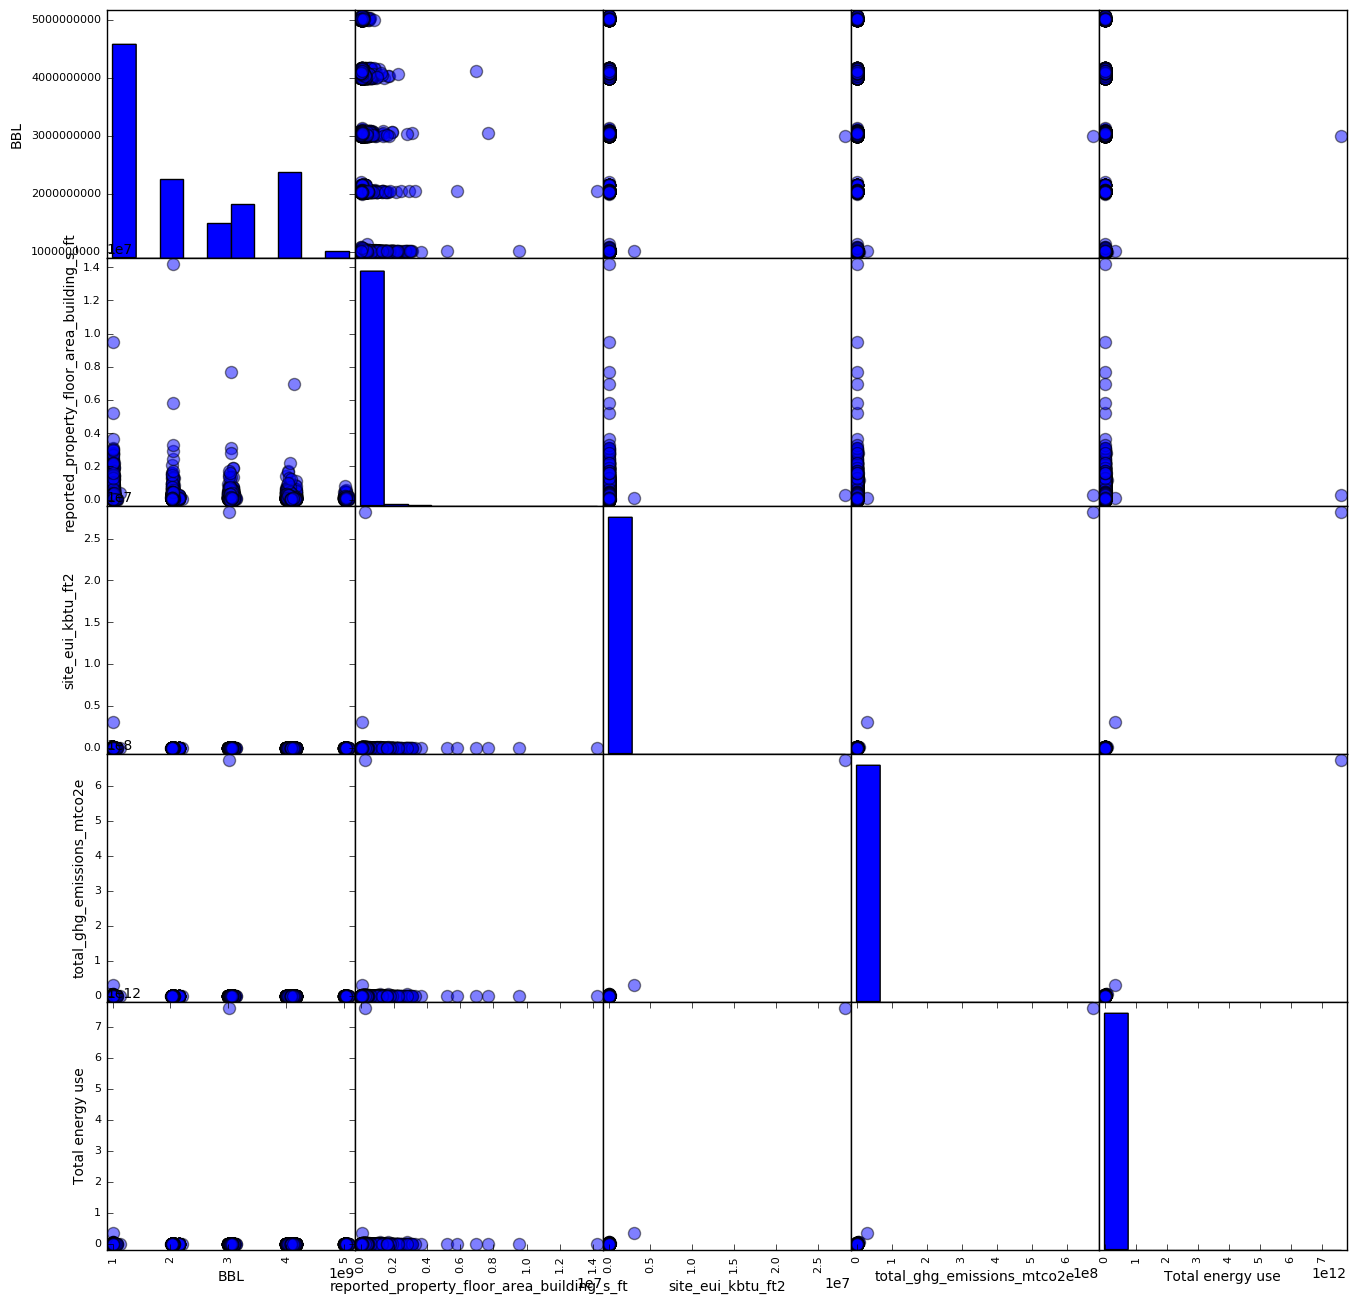

In [283]:
# Plotting all numeric variables against each other to get a general sense of any existing relationship 

from pandas.tools.plotting import scatter_matrix
scatter_matrix(eUse_data_num, s = 300, figsize = (16, 16))

In [191]:
# MPLUTO data 

os.system("unzip " + os.getenv("PUIDATA") + "/" + "mn_mappluto_16v1.zip")
zip_ref = zipfile.ZipFile(os.getenv('PUIDATA') + '/' + "mn_mappluto_16v1.zip", 'r')
zip_ref.extractall(os.getenv('PUIDATA'))
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile object at 0x7ff3e724f710>>

In [192]:
mpluto = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/' + "MNMapPLUTO.shp")

In [193]:
mpluto.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [194]:
mpluto.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [195]:
mpluto.drop([u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
         u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidFAR',
       u'RetailArea', u'SHAPE_Area', u'SHAPE_Leng',    u'SPDist1',
          u'SPDist2',    u'Sanborn',  u'SanitBoro',  u'SanitDist',
         u'SanitSub', u'SchoolDist',  u'SplitZone',  u'StrgeArea',
           u'TaxMap',  u'Tract2010',   u'UnitsRes',
          u'Version',     u'XCoord',     u'YCoord', u'YearAlter1',
       u'YearAlter2',     u'ZMCode',    u'ZipCode',
        u'ZoneDist1',  u'ZoneDist2',  u'ZoneDist3',  u'ZoneDist4',
          u'ZoneMap',   u'geometry'], axis = 1, inplace = True)

In [196]:
mpluto.head() # Checking reduced dataframe

,BBL,UnitsTotal,YearBuilt
0,1.015450e+09,18,1920
1,1.007238e+09,50,1914
2,1.016800e+09,10,1910
3,1.013850e+09,32,1928
4,1.011970e+09,26,1900


In [197]:
mpluto.dtypes # Checking data types

BBL           float64
UnitsTotal      int64
YearBuilt       int64
dtype: object

In [198]:
mpluto.isnull().sum() # Checking for NaN values 

BBL           0
UnitsTotal    0
YearBuilt     0
dtype: int64

#### 2. Data merge

In [215]:
eUse_data_num.rename(columns = {'nyc_borough_block_and_lot_bbl' : 'BBL'}, inplace = True) # Renaming column 

In [216]:
eUse_data_num.columns

Index([u'BBL', u'reported_property_floor_area_building_s_ft',
       u'site_eui_kbtu_ft2', u'total_ghg_emissions_mtco2e',
       u'Total energy use'],
      dtype='object')

In [217]:
eUse_mpluto = pd.merge(eUse_data_num, mpluto, on = 'BBL')

In [218]:
eUse_mpluto.head()

,BBL,reported_property_floor_area_building_s_ft,site_eui_kbtu_ft2,total_ghg_emissions_mtco2e,Total energy use,UnitsTotal,YearBuilt
0,1.013110e+09,330000.0,125.4,3556.4,41382000.0,56,1977
1,1.010140e+09,841709.0,154.9,9525.0,130380724.1,2,1999
2,1.007660e+09,59468.0,122.3,584.4,7272936.4,8,1912
3,1.008150e+09,364000.0,117.0,3613.0,42588000.0,24,1954
4,1.005050e+09,235370.0,82.1,1392.3,19323877.0,24,1926


#### 3. Data plotting

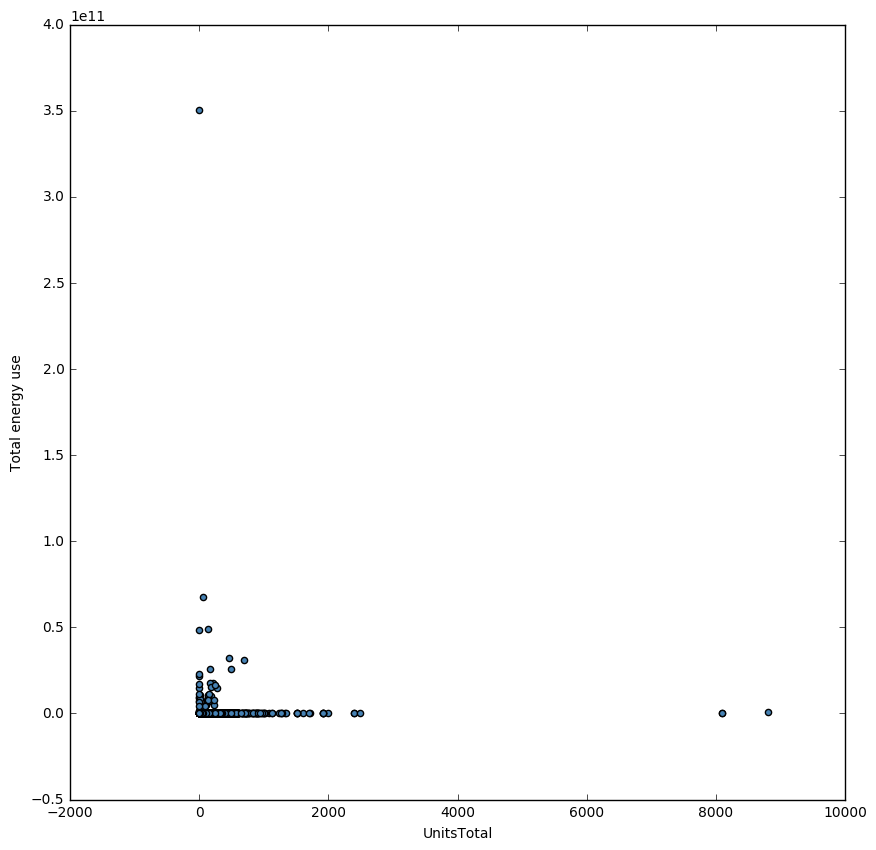

In [262]:
eUse_mpluto.plot.scatter('UnitsTotal', 'Total energy use', figsize = (10, 10), color = 'SteelBlue')

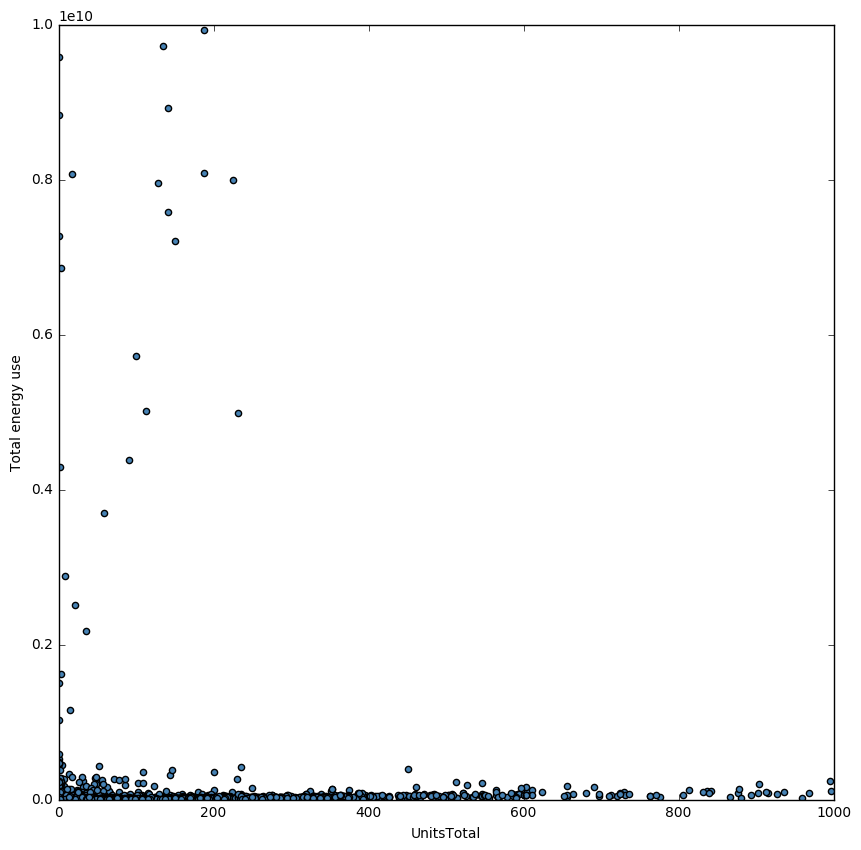

In [261]:
# Zooming in 

eUse_mpluto.plot.scatter('UnitsTotal', 'Total energy use', 
                         xlim = (0, 1000), ylim = (0, 1e10), 
                         figsize = (10, 10), color = 'SteelBlue')

In [331]:
# Removing outliers, which are zero values of total energy use and number of units 

eUse_mpluto_cut = eUse_mpluto[eUse_mpluto['Total energy use'] > 0]
eUse_mpluto_cut = eUse_mpluto_cut[eUse_mpluto['UnitsTotal'] > 0]
#eUse_mpluto_cut = eUse_mpluto[eUse_mpluto['Total energy use'] <= 1000]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [332]:
eUse_mpluto_cut.head()

,BBL,reported_property_floor_area_building_s_ft,site_eui_kbtu_ft2,total_ghg_emissions_mtco2e,Total energy use,UnitsTotal,YearBuilt
0,1.013110e+09,330000.0,125.4,3556.4,41382000.0,56,1977
1,1.010140e+09,841709.0,154.9,9525.0,130380724.1,2,1999
2,1.007660e+09,59468.0,122.3,584.4,7272936.4,8,1912
3,1.008150e+09,364000.0,117.0,3613.0,42588000.0,24,1954
4,1.005050e+09,235370.0,82.1,1392.3,19323877.0,24,1926


In [333]:
eUse_mpluto_cut.shape

(4990, 7)

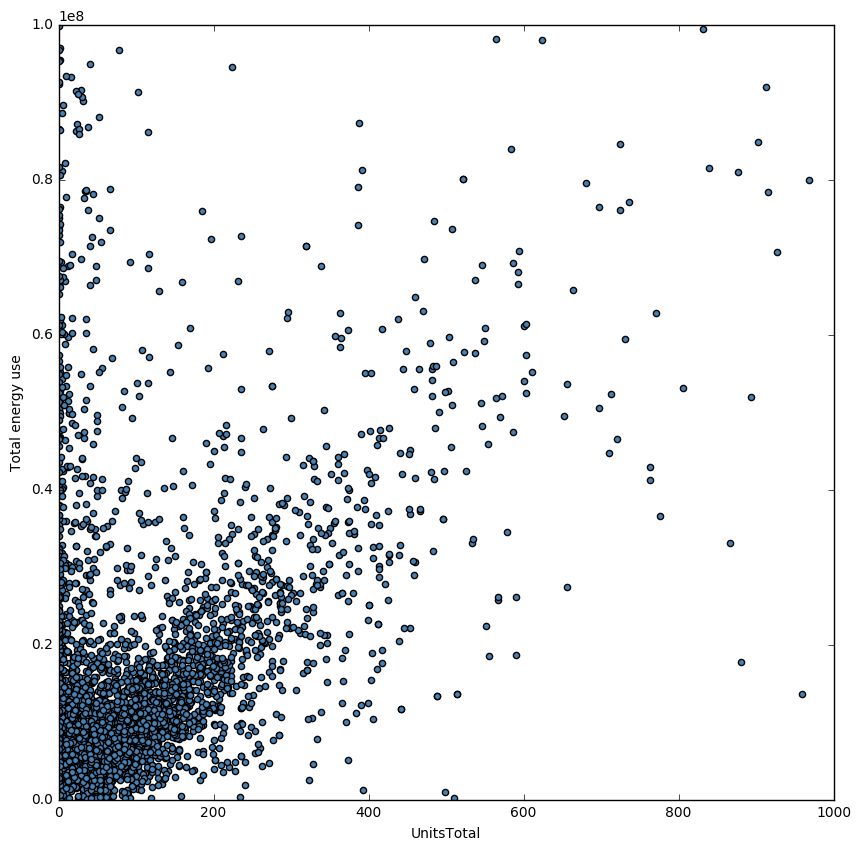

In [334]:
eUse_mpluto_cut.plot.scatter('UnitsTotal', 'Total energy use', 
                         xlim = (0, 1000), ylim = (0, 1e8), 
                         figsize = (10, 10), color = 'SteelBlue')

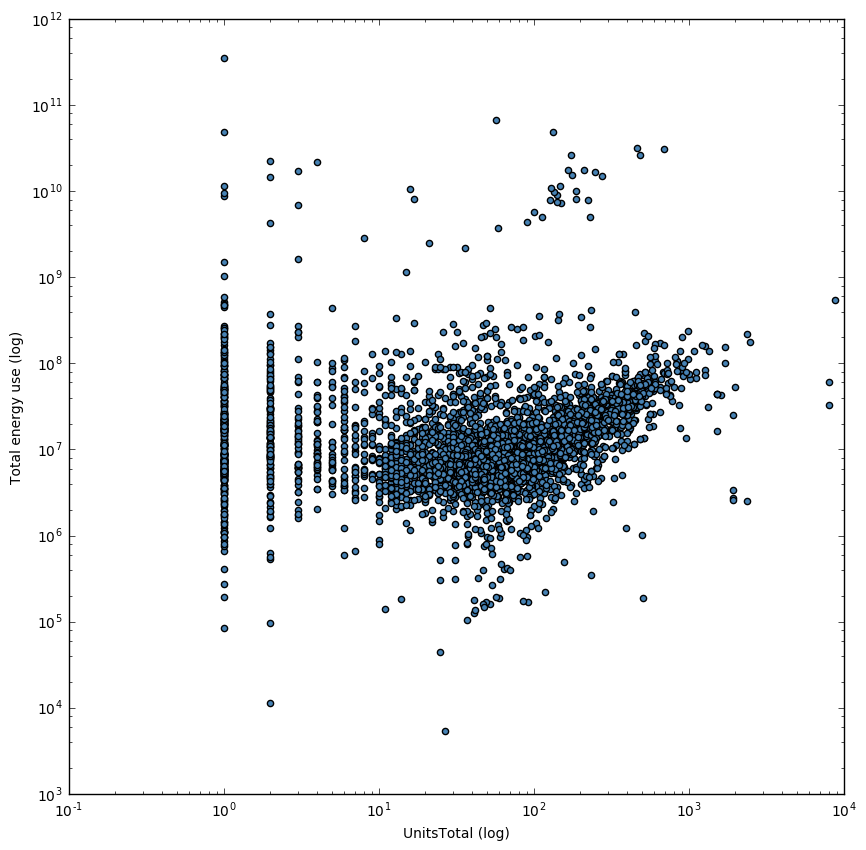

In [335]:
# Log plot

eUse_mpluto_cut.plot.scatter('UnitsTotal', 'Total energy use',
                            figsize = (10, 10),
                            loglog = True,
                            color = 'SteelBlue')

pl.ylabel('Total energy use (log)')
pl.xlabel('UnitsTotal (log)')

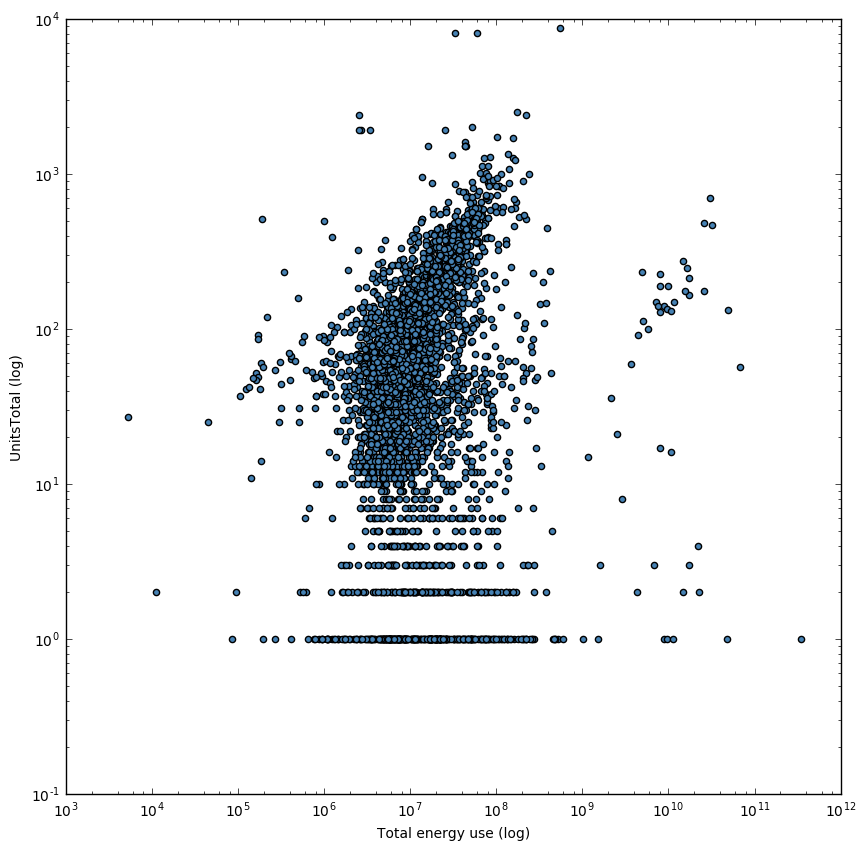

In [336]:
# Switching x and y values

eUse_mpluto_cut.plot.scatter('Total energy use', 'UnitsTotal',
                            figsize = (10, 10),
                            loglog = True,
                            color = 'SteelBlue')

pl.xlabel('Total energy use (log)')
pl.ylabel('UnitsTotal (log)')

#### 4. Modeling

In [337]:
eUse_mpluto_cut.columns

Index([                                       u'BBL',
       u'reported_property_floor_area_building_s_ft',
                                u'site_eui_kbtu_ft2',
                       u'total_ghg_emissions_mtco2e',
                                 u'Total energy use',
                                       u'UnitsTotal',
                                        u'YearBuilt'],
      dtype='object')

In [338]:
eUse_mpluto_log = eUse_mpluto_cut.drop([u'BBL', 
                                        u'reported_property_floor_area_building_s_ft', 
                                        u'site_eui_kbtu_ft2',
                                        u'total_ghg_emissions_mtco2e',
                                        u'YearBuilt'], axis = 1)

In [339]:
eUse_mpluto_log.head()

,Total energy use,UnitsTotal
0,41382000.0,56
1,130380724.1,2
2,7272936.4,8
3,42588000.0,24
4,19323877.0,24


In [340]:
eUse_mpluto_log['Total energy use (log)'] = np.log(eUse_mpluto_cut['Total energy use'])
eUse_mpluto_log['UnitsTotal (log)'] = np.log(eUse_mpluto_cut['UnitsTotal'])
eUse_mpluto_log = eUse_mpluto_log[eUse_mpluto_log['UnitsTotal (log)'] > 0]

In [341]:
eUse_mpluto_log.head()

,Total energy use,UnitsTotal,Total energy use (log),UnitsTotal (log)
0,41382000.0,56,17.538357,4.025352
1,130380724.1,2,18.685969,0.693147
2,7272936.4,8,15.799671,2.079442
3,42588000.0,24,17.567083,3.178054
4,19323877.0,24,16.776852,3.178054


In [342]:
eUse_mpluto_log.describe()

,Total energy use,UnitsTotal,Total energy use (log),UnitsTotal (log)
count,4.656000e+03,4656.000000,4656.000000,4656.000000
mean,1.350539e+08,121.269115,16.222543,4.118815
std,1.752809e+09,268.519348,1.165433,1.237051
min,5.344000e+03,2.000000,8.583730,0.693147
25%,5.871322e+06,35.000000,15.585590,3.555348
50%,9.183819e+06,68.000000,16.032954,4.219508
75%,1.793921e+07,130.250000,16.702499,4.869450
max,6.779388e+10,8805.000000,24.939738,9.083075


In [343]:
eUse_mpluto_log.shape

(4656, 4)

In [344]:
# Regress Units on Energy

lm1 = smf.ols(formula = 'eUse_mpluto_log["UnitsTotal (log)"] ~ eUse_mpluto_log["Total energy use (log)"]', 
             data = eUse_mpluto_log).fit()
print 'R2 = %f'%lm1.rsquared
print lm1.params

R2 = 0.052083
Intercept                                    0.189035
eUse_mpluto_log["Total energy use (log)"]    0.242242
dtype: float64


In [345]:
# Regress Energy on Units

lm2 = smf.ols(formula = 'eUse_mpluto_log["Total energy use (log)"] ~ eUse_mpluto_log["UnitsTotal (log)"]', 
             data = eUse_mpluto_log).fit()
print 'R2 = %f'%lm2.rsquared
print lm2.params

R2 = 0.052083
Intercept                              15.336976
eUse_mpluto_log["UnitsTotal (log)"]     0.215005
dtype: float64


In [346]:
# Double checking the regression results 

x = eUse_mpluto_log["UnitsTotal (log)"]
y = eUse_mpluto_log["Total energy use (log)"]
X = sm.add_constant(x)
linmodel = sm.OLS(y, X).fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Total energy use (log)   R-squared:                       0.052
Model:                                OLS   Adj. R-squared:                  0.052
Method:                     Least Squares   F-statistic:                     255.7
Date:                    Tue, 18 Oct 2016   Prob (F-statistic):           4.49e-56
Time:                            16:08:07   Log-Likelihood:                -7194.4
No. Observations:                    4656   AIC:                         1.439e+04
Df Residuals:                        4654   BIC:                         1.441e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               15.3370      0.058    265.244      0.000        15.224    15.450
UnitsTotal (log)     0.2150      0.013     15.991      0.000         0.189     0.241
==============================================================================
Omnibus:                     2203.946   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31432.284
Skew:                           1.891   Prob(JB):                         0.00
Kurtosis:                      15.154   Cond. No.                         15.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

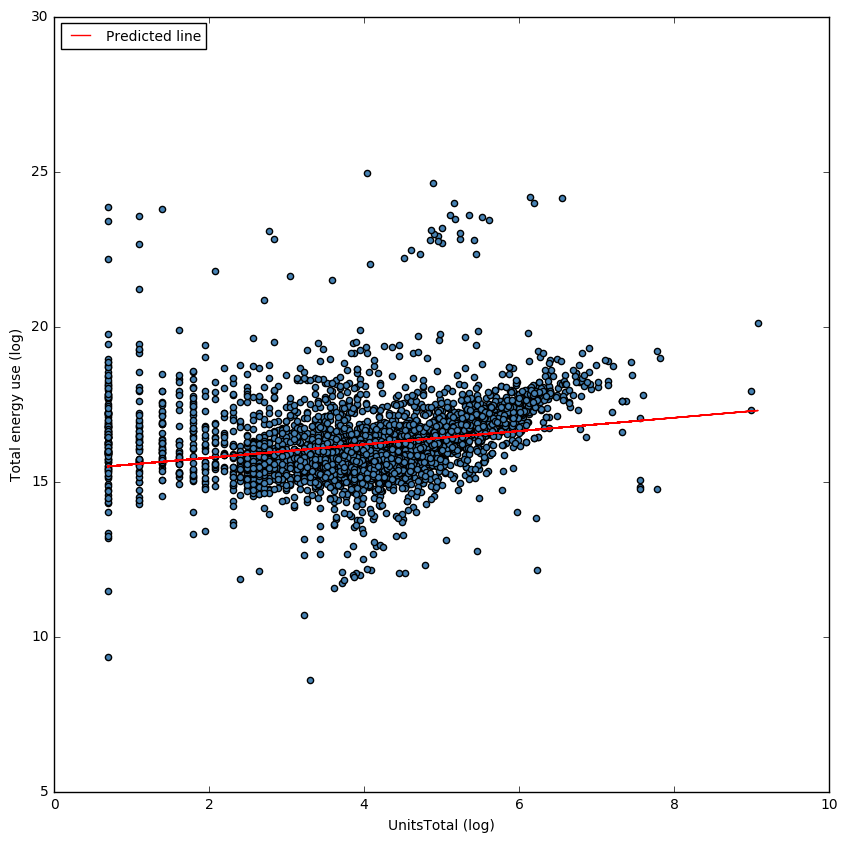

In [353]:
lin_pred = linmodel.predict(X)

eUse_mpluto_log.plot.scatter('UnitsTotal (log)', 'Total energy use (log)',
                             figsize = (10, 10),
                             color = 'SteelBlue')

pl.plot(eUse_mpluto_log['UnitsTotal (log)'], lin_pred, c = 'red', label = 'Predicted line')
pl.legend(fontsize = 10, loc = "upper left")

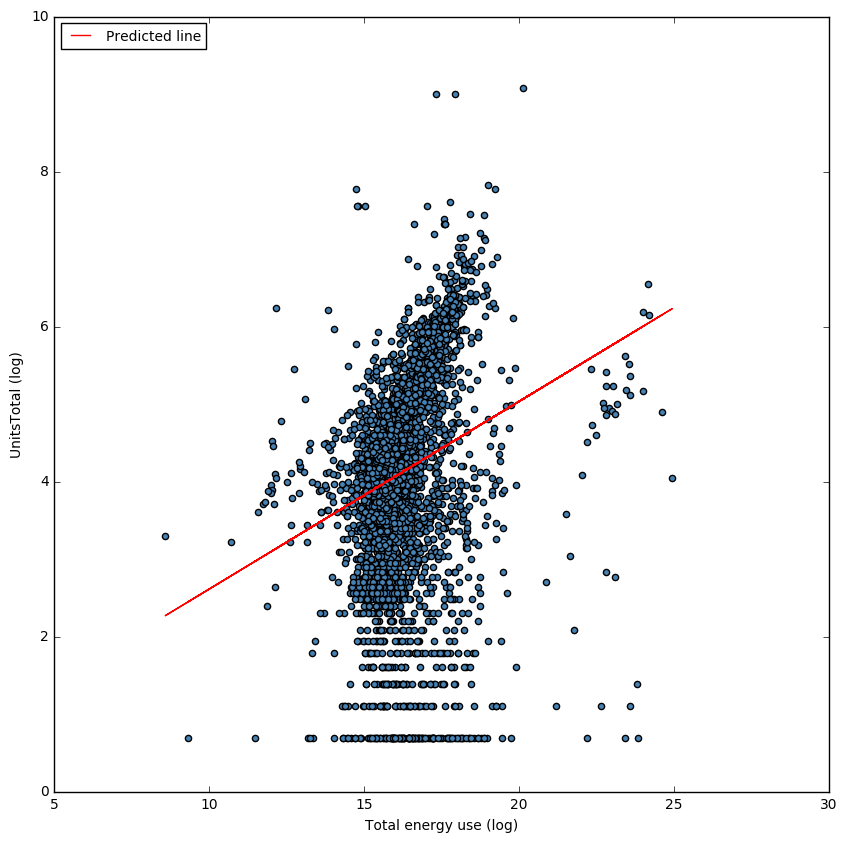

In [355]:
lmy = lm1.predict(eUse_mpluto_log['Total energy use (log)'])

eUse_mpluto_log.plot.scatter('Total energy use (log)', 'UnitsTotal (log)',
                             figsize = (10, 10),
                             color = 'SteelBlue')

pl.plot(eUse_mpluto_log['Total energy use (log)'], lmy, c = 'red', label = 'Predicted line')
pl.legend(fontsize = 10, loc = "upper left")